# Estimating Correlation Using Discrete Copulas

In [388]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

from scipy.stats import truncnorm, poisson, norm, nbinom, multivariate_normal
import scipy.stats as stats

import tools as tl

# load data
data1_4 = pd.read_csv("mt-datasets/Donor1_CD4_Genes.csv")
# normalization
data_norm = tl.RPM(data1_4)
fitted_para = pd.read_csv('fitted_data/fitted_para.csv')

data_pro = data_norm[fitted_para.columns.to_list()]
data_pro = data_pro.reset_index(drop=True)
N = data_pro.shape[0]

Gaussian Copula

In [418]:
def cdgaussian_copulas(u, range, rho):
    '''inv2 = norm.ppf(u)
    a, b = range
    inv_a = norm.ppf(a)
    inv_b = norm.ppf(b)
    mu = inv2*rho
    sigma = np.sqrt(1-rho ** 2)
    inv1 = truncnorm.rvs((inv_a-mu) / sigma, (inv_b-mu) /
                         sigma, loc=inv2*rho, scale=sigma)
    val = norm.cdf(inv1)'''
    u = np.asarray(u)
    
    # Compute inverse CDF (norm.ppf) for u
    inv2 = norm.ppf(u)
    
    # Extract lower and upper bounds from the ranges matrix
    a = [lis[0] for lis in range]
    b = [lis[1] for lis in range]
    
    # Compute inverse CDF for the ranges
    inv_a = norm.ppf(a)
    inv_b = norm.ppf(b)
    
    # Compute mu and sigma for the truncated normal distribution
    mu = inv2 * rho
    sigma = np.sqrt(1 - rho ** 2)
    
    # Calculate the normalized bounds for the truncated normal distribution
    lower_bounds = (inv_a - mu) / sigma
    upper_bounds = (inv_b - mu) / sigma
    
    # Generate truncated normal samples in a vectorized manner
    inv1 = truncnorm.rvs(lower_bounds, upper_bounds, loc=mu, scale=sigma, size=len(u))
    
    # Compute the cumulative distribution function (CDF) of the generated samples
    val = norm.cdf(inv1)
    
    return val
cdgaussian_copulas([0.5,0.4], [[0.4,0.7],[0.2,0.8]], 0.5)

array([0.5183115 , 0.37842682])

In [391]:
def zinb_cdf(k, para):
    """
    Calculate the CDF of the Zero-Inflated Negative Binomial (ZINB) distribution.

    Returns:
    cdf : float
        The cumulative probability of the ZINB distribution at k.
    """
    # CDF of the Negative Binomial distribution
    mu, r, p_zero = para
    p = 1 - mu / (mu+r)
    nb_cdf = stats.nbinom.cdf(k, r, p)

    return 1-p_zero + p_zero * nb_cdf

In [392]:
def get_range(data, para):
    N = data.shape[0]
    data_range = pd.DataFrame(index=range(N), columns=data.columns.to_list())
    for col in data.columns:
        para_0 = para[col]
        if not pd.isna(para_0[2]):
            for i in range(N):
                x = data_pro[col][i]
                data_range.loc[i, col] = [x, zinb_cdf(
                    x-1, para_0), zinb_cdf(x, para_0)]
        else:
            for i in range(N):
                x = data_pro[col][i]
                data_range.loc[i, col] = [x, stats.nbinom.cdf(
                    x-1, para_0[0], para_0[1]), stats.nbinom.cdf(x, para_0[0], para_0[1])]
    return data_range

data_range=get_range(data_pro, fitted_para)

In [393]:
def truncnorm_prop_rho(x, sigma):  # proposal for rho (non-negative)
    return truncnorm.rvs((-1-x) / sigma, (1-x) / sigma, loc=x, scale=sigma)

def truncnorm_rho_pdf(x,x_p,sigma):
    rv = truncnorm((-1-x) / sigma, (1-x) / sigma, loc=x, scale=sigma)
    return rv.pdf(x_p)
def set_initial(data):
    N = data.shape[0]
    data_initial = pd.DataFrame(index=range(N), columns=data.columns.to_list())
    for col in data.columns:
        for i in range(N):
            data_initial.loc[i,col] = [random.uniform(
                data[col][i][1], data[col][i][2])]
            data_initial.loc[i,col]+=data[col][i][1:]
    return data_initial

initial_u = set_initial(data_range)

In [423]:
def update_u(u1_initial, u2_pack, rho):
    N = u1_initial.shape[0]
    col2 = u2_pack.columns
   
    u2 = pd.DataFrame(index=range(N), columns=col2.to_list())
    u_condition = [u1_initial[u1_initial.columns[0]][i][0] for i in range(N)]
    ranges = [u2_pack[col2[0]][i][1:] for i in range(N)]

    new_val = cdgaussian_copulas(u_condition,ranges,rho)
    u2[col2[0]] = [[new_val[i],u2_pack[col2[0]][i][1],u2_pack[col2[0]][i][2]] for i in range(N)]
    
    return u2

## MH for rho

In [462]:
def log_copulas_val(u1,u2,rho):
    mean = [0,0]
    cov = [[1,rho],[rho,1]]
    '''rv = multivariate_normal(mean,cov)
    return np.log(rv.pdf([norm.ppf(u1),norm.ppf(u2)]))'''
    inv_u1 = norm.ppf(u1)
    inv_u2 = norm.ppf(u2)

    # Create a multivariate normal distribution object
    rv = multivariate_normal(mean, cov)
    
    # Combine inv_u1 and inv_u2 into a 2D array for vectorized evaluation
    inv_uv = np.column_stack((inv_u1, inv_u2))
    
    # Calculate the log of the PDF values for all pairs in inv_uv
    log_pdf_vals = rv.logpdf(inv_uv)

    return log_pdf_vals

def gc_acceptance_ratio(u, u_p,rho_vals):
    rho,rho_p = rho_vals
    u1,u2 = u
    u1_p,u2_p = u_p

    u1 = u1.to_numpy()
    u2 = u2.to_numpy()
    u1_p= u1_p.to_numpy()
    u2_p = u2_p.to_numpy()
    u1 = [li[0][0] for li in u1]
    u2 = [li[0][0] for li in u2]
    u1_p = [li[0][0] for li in u1_p]
    u2_p = [li[0][0] for li in u2_p]
    
   
    acc =sum( log_copulas_val(u1_p,u2_p,rho_p))-sum(log_copulas_val(u1,u2,rho))
    return acc
#gc_acceptance_ratio(initial_u[['MT-CO1']],initial_u[['MT-CO2']],(0.4,0.5),0.01)


In [396]:
import numpy as np
from scipy.stats import nbinom, norm

def negative_binomial_marginal(num,r, p, u_raw):
   
    N, J = num.shape

    rtn = [np.zeros((N, J)), np.zeros((N, J))]
    
    for j in range(J):
        for n in range(N):
            
            Ubound = nbinom.cdf(num[n, j],r[j] , p[j])
            Lbound = 0
            if num[n, j] > 0:
                Lbound = nbinom.cdf(num[n, j] - 1, r[j], p[j])
            UmL = Ubound - Lbound
            rtn[0][n, j] = norm.ppf(Lbound + UmL * u_raw[n, j])
            rtn[1][n, j] = np.log(UmL)
    
    return rtn
def apply_ng_marginal(name1,name2,u):
    num = data_pro[[name1,name2]].values
    r = fitted_para.loc[0,[name1,name2]].values
    p = fitted_para.loc[1,[name1,name2]].values
    u_raw = u
    return negative_binomial_marginal(num,r, p, u_raw)

In [467]:
def metropolis_hastings_gc(u1, u2, sigma, n_iter=10000, burn_in=2000, thin=5):

    trace = np.zeros(n_iter)
    trace[0] = 0.5

    acceptance_rate = np.zeros(n_iter)
    rho = trace[0]

    for i in range(1, n_iter):
        rho = trace[i-1]
        rho_p = truncnorm_prop_rho(rho, sigma)

        u1_p = update_u(u2, u1, rho_p)
        u2_p = update_u(u1, u2, rho_p)

        alpha = gc_acceptance_ratio(
            (u1, u2), (u1_p, u2_p), (rho, rho_p), sigma)
        u = np.log(np.random.uniform(0., 1.))
        
        if u < alpha:
            trace[i] = rho_p
            acceptance_rate[i-1] = 1
            u1 = u1_p
            u2 = u2_p
        else:
            trace[i] = rho
    print(u1.columns[0]+' and '+u2.columns[0]+" acceptance rate is: %.2f" % acceptance_rate[burn_in:].mean())
    return pd.DataFrame(trace[burn_in::thin])

trace_0 = metropolis_hastings_gc(initial_u[['MT-CO1']], initial_u[['MT-CO3']], sigma=0.01, n_iter=5000, burn_in=1000, thin=5)

MT-CO1 and MT-CO3 acceptance rate is: 0.47


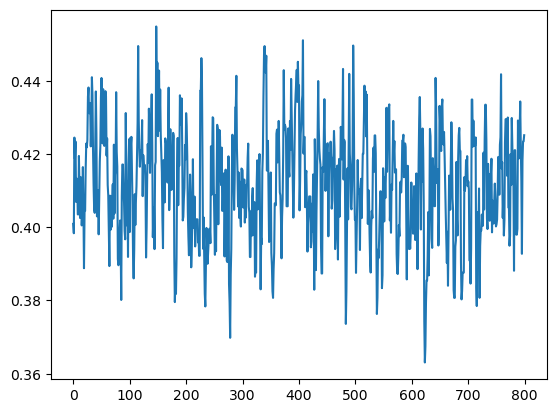

In [468]:
plt.plot(trace_0[0])

In [471]:
names = data_range.columns.to_list()
traces = pd.DataFrame(index=names, columns=names)

cor_o = np.zeros((13,13))
for i in range(13):
    for j in range(i+1,13):
        tra = metropolis_hastings_gc(initial_u[[names[i]]], initial_u[[names[j]]], sigma=0.01, n_iter=5000, burn_in=1000, thin=5)
        traces.loc[names[i],names[j]]= [tra[:100].mean()-tra[-100:].mean(),tra,tra.mean()]
        cor_o[i,j]=tra.mean()
        print(cor_o[i,j])
print(cor_o)


MT-CO1 and MT-CO2 acceptance rate is: 0.47
0.3974134307493613


/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_34356/2676697351.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cor_o[i,j]=tra.mean()


MT-CO1 and MT-CO3 acceptance rate is: 0.46
0.4101983725895667


/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_34356/2676697351.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cor_o[i,j]=tra.mean()


MT-CO1 and MT-CYB acceptance rate is: 0.41
0.270869323853467


/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_34356/2676697351.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cor_o[i,j]=tra.mean()


MT-CO1 and MT-ND1 acceptance rate is: 0.47
0.10789021276262552


/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_34356/2676697351.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cor_o[i,j]=tra.mean()


MT-CO1 and MT-ND2 acceptance rate is: 0.48
0.1339473434225994


/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_34356/2676697351.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cor_o[i,j]=tra.mean()


MT-CO1 and MT-ND3 acceptance rate is: 0.49
0.22795239432396563


/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_34356/2676697351.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cor_o[i,j]=tra.mean()
